_Face Recogniser_

## 1. Task description

The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

In [78]:
from face_utility import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
import time

data, labels = load_data()

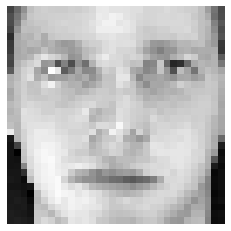

In [80]:
# Display a single example.
show_single_face(data[0, :])

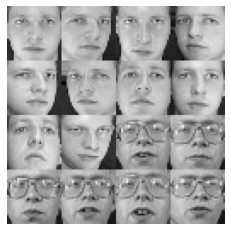

In [81]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

In [82]:
# Normalization
data = data / 255

# Partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares

In [83]:
def l2_rls_train(data, labels, regularisation_param = 0):
      """
      By supplying sufficient training samples and expected output the l2_rls_train function returns weights which are optimised for new
      samples. It's possible to add a regularisation hyperparameter to reduce overfitting to the training data. The function simulates a
      (regularised) least squares classification model.

      data: matrix of size (N x d), so it has N rows, N being the number of input training samples, and d being the number of features,
            which in this case will be 1024, representing the number of pixels
      labels: matrix of size (N x c), so it has N rows, N being the number of expected output labels of the N input training samples,
            and c being the number of output values per sample which in this case will be 1024, representing the number of pixels
      regularisation_param: integer which represents the regularisation hyperparameter, it's used to reduce overfitting to the training
            data by turning this model into a l2-regularisation least squares model and it's default value is zero (so if called without
            it weights the model will be a regular least squares model)

      Returns:
      w: matrix of size (d+1 x c) with d being the number of features per sample plus one, which in this case will be 1025,
            representing the weights that will be applied to the values of a testing sample's pixels and c being the number of
            output values per sample 
      """

      features_per_sample = len(data[0]) + 1 # This will be d, the number of features per sample, which in our case is pixels per image
                                             # plus one for the extension
      sample_number = len(data)              # This will be N, the number of samples
      
      # Determine if system is overdetermined or underdetermined
      isOverdetermined = False
      if(sample_number >= features_per_sample):
            isOverdetermined = True


      X, y = data, labels

      # Expand X with a column of ones.
      extension = np.ones((sample_number, 1), dtype=int)     # Column of 1s
      X_tilde = np.concatenate((extension, X), axis=1)       # Each sample starts wiht 1 now

      # Compute the coefficient vector.
      w = 0

      if(regularisation_param == 0):
            w= np.linalg.pinv(X_tilde) @ y
      else:
            if(isOverdetermined):
                  # overdetermined (N>d)
                  w = np.linalg.inv((X_tilde.T @ X_tilde + regularisation_param * np.identity(features_per_sample))) @ X_tilde.T @ y 
            else:
                  # underdetermined (N<d)
                  w = X_tilde.T @ np.linalg.inv((X_tilde @ X_tilde.T + regularisation_param * np.identity(sample_number))) @ y       

      # Return model parameters.
      return w

In [84]:
def l2_rls_predict(w, data):
    """
    By supplying trained weights, testing samples and a boolean signifying the type of classification the l2_rls_predict
    function returns a matrix of predicted outputs which can later be thresholded to acquire predicted class labels for
    the specified testing samples.

    w: matrix of size (d+1 x c) with d being the number of features per sample plus one, which in this case will be 1025,
        representing the weights that will be applied to the values of a testing sample's pixels and c being the number of
        output values per sample 
    data: matrix of size (N x c), so it has N rows, N being the number of input testing samples, and c being the number of
        output numbers per sample 

    Returns:
    predicted_y: matrix of size (N x c), so it has N rows, N being the number of testing samples to be classified, and c being
        the number of output values per sample; can later be thresholded to acquire predicted class labels for the specified
        testing samples
    """
    sample_number = len(data)    # This will be N, the number of samples

    extension = np.ones((sample_number, 1), dtype=int)          # Column of 1s
    data_tilde = np.concatenate((extension, data), axis=1)      # Each sample starts wiht 1 now


    predicted_y = np.squeeze(data_tilde @ w)
    return np.squeeze(predicted_y)

In [85]:
# Usinf three subjects per training and the rest would be for testing.

# Classifier one specification
c_one_T = 0
c_one_regularisation = 0
subject_one = 1
subject_two = 30
c_one_class_one_y = -1
c_one_class_two_y = 1
c_one_trials = 50

# Classifier two specification
c_two_T = 0.5
c_two_regularisation = 0
subject_one = 1
subject_two = 30
c_two_class_one_y = 0
c_two_class_two_y = 1
c_two_trials = 50

# Classifier two specification
c_three_T = 15.5
c_three_regularisation = 0
subject_one = 1
subject_two = 30
c_three_class_one_y = 1
c_three_class_two_y = 30
c_three_trials = 50

In [86]:
c_one_overall_train_error = 0
c_one_overall_test_error = 0

c_one_train_error_rates = []
c_one_test_error_rates = []

c_one_train_accuracy = []
c_one_test_accuracy = []

for i in range(c_one_trials):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    # Get the 1st and 30th subject's face data for training and testing
    tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
    te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

    # Training samples and corresponding labels
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    tr_label = np.array(tr_label, dtype=int) # Original returns uint8

    # Testing samples and corresponding labels
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    te_label = np.array(te_label, dtype=int) # Original returns uint8

    # Using +1/-1 labelling
    output_labels = tr_label.copy()
    output_labels[tr_label == subject_one] = c_one_class_one_y
    output_labels[tr_label == subject_two] = c_one_class_two_y

    # Train weights 
    w = l2_rls_train(tr_data, output_labels, c_one_regularisation)


    # QUERYING DATA

    # Query with train data
    predicted_labels = l2_rls_predict(w, tr_data)

    # Thresholding
    predicted_labels[predicted_labels >= c_one_T] = subject_two
    predicted_labels[predicted_labels < c_one_T] = subject_one
    train_result = tr_label == predicted_labels

    # Query with test data
    predicted_labels = l2_rls_predict(w, te_data)
    
    # Thresholding
    predicted_labels[predicted_labels >= c_one_T] = subject_two
    predicted_labels[predicted_labels < c_one_T] = subject_one
    test_result = te_label == predicted_labels


    # CALCULATING ERROR RATES

    # Calculate train error rate
    incorrect_counter = 0
    for j in range(len(train_result)):
        if(not train_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_one_overall_train_error = c_one_overall_train_error + (incorrect_counter/len(train_result))/c_one_trials
    c_one_train_error_rates.append((incorrect_counter/len(train_result)))
    c_one_train_accuracy.append(1 - (incorrect_counter/len(train_result)))

    # Calculate test error rate
    incorrect_counter = 0
    for j in range(len(test_result)):
        if(not test_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_one_overall_test_error = c_one_overall_test_error + (incorrect_counter/len(test_result))/c_one_trials
    c_one_test_error_rates.append((incorrect_counter/len(test_result)))
    c_one_test_accuracy.append(1 - (incorrect_counter/len(test_result)))
    
print("##### CLASSIFIER 1 #####")
print("Wights trained with three images per subject from subjects ", str(subject_one), " and ", str(subject_two))
print("")
print("After ", str(c_one_trials), "trials: ")
print("Testing error rate mean: ", np.mean(c_one_test_error_rates))
print("Training error rate mean: ", np.mean(c_one_train_error_rates))
print("Testing accuracy mean: ", np.mean(c_one_test_accuracy))
print("Training accuracy mean: ", np.mean(c_one_train_accuracy))

##### CLASSIFIER 1 #####
Wights trained with three images per subject from subjects  1  and  30

After  50 trials: 
Testing error rate mean:  0.06714285714285713
Training error rate mean:  0.0
Testing accuracy mean:  0.9328571428571428
Training accuracy mean:  1.0


Repeat the same experiment for classifier 2.

In [87]:
c_two_overall_train_error = 0
c_two_overall_test_error = 0

c_two_train_error_rates = []
c_two_test_error_rates = []

c_two_train_accuracy = []
c_two_test_accuracy = []

for i in range(c_two_trials):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    # Get the 1st and 30th subject's face data for training and testing
    tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
    te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

    # Training samples and corresponding labels
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    tr_label = np.array(tr_label, dtype=int) # Original returns uint8

    # Testing samples and corresponding labels
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    te_label = np.array(te_label, dtype=int) # Original returns uint8

    # Using +1/0 labelling
    output_labels = tr_label.copy()
    output_labels[tr_label == subject_one] = c_two_class_one_y
    output_labels[tr_label == subject_two] = c_two_class_two_y

    # Train weights 
    w = l2_rls_train(tr_data, output_labels, c_two_regularisation)


    # QUERYING DATA

    # Query with train data
    predicted_labels = l2_rls_predict(w, tr_data)
    
    # Thresholding
    predicted_labels[predicted_labels >= c_two_T] = subject_two
    predicted_labels[predicted_labels < c_two_T] = subject_one
    train_result = tr_label == predicted_labels

    # Query with test data
    predicted_labels = l2_rls_predict(w, te_data)

    # Thresholding
    predicted_labels[predicted_labels >= c_two_T] = subject_two
    predicted_labels[predicted_labels < c_two_T] = subject_one
    test_result = te_label == predicted_labels


    # CALCULATING ERROR RATES

    # Calculate train error rate
    incorrect_counter = 0
    for j in range(len(train_result)):
        if(not train_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_two_overall_train_error = c_two_overall_train_error + (incorrect_counter/len(train_result))/c_one_trials
    c_two_train_error_rates.append((incorrect_counter/len(train_result)))
    c_two_train_accuracy.append(1 - (incorrect_counter/len(train_result)))

    # Calculate test error rate
    incorrect_counter = 0
    for j in range(len(test_result)):
        if(not test_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_two_overall_test_error = c_two_overall_test_error + (incorrect_counter/len(test_result))/c_one_trials
    c_two_test_error_rates.append((incorrect_counter/len(test_result)))
    c_two_test_accuracy.append(1 - (incorrect_counter/len(test_result)))
    
print("##### CLASSIFIER 2 #####")
print("Wights trained with three images per subject from subjects ", str(subject_one), " and ", str(subject_two))
print("")
print("After ", str(c_two_trials), "trials: ")
print("Testing error rate mean: ", np.mean(c_two_test_error_rates))
print("Training error rate mean: ", np.mean(c_two_train_error_rates))
print("Testing accuracy mean: ", np.mean(c_two_test_accuracy))
print("Training accuracy mean: ", np.mean(c_two_train_accuracy))

##### CLASSIFIER 2 #####
Wights trained with three images per subject from subjects  1  and  30

After  50 trials: 
Testing error rate mean:  0.07999999999999999
Training error rate mean:  0.0
Testing accuracy mean:  0.9199999999999998
Training accuracy mean:  1.0


Repeat the same experiment for classifier 3.

In [88]:
c_three_overall_train_error = 0
c_three_overall_test_error = 0

c_three_train_error_rates = []
c_three_test_error_rates = []

c_three_train_accuracy = []
c_three_test_accuracy = []

for i in range(c_three_trials):
    tr_ind, te_ind = partition_data(labels, num_per_class=3)

    # Get the 1st and 30th subject's face data for training and testing
    tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
    te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

    # Training samples and corresponding labels
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    tr_label = np.array(tr_label, dtype=int) # Original returns uint8

    # testing samples and corresponding labels
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    te_label = np.array(te_label, dtype=int) # Original returns uint8

    # Using +1/+30 labelling
    output_labels = tr_label.copy()
    output_labels[tr_label == subject_one] = c_three_class_one_y
    output_labels[tr_label == subject_two] = c_three_class_two_y

    # Train weights 
    w = l2_rls_train(tr_data, output_labels, c_three_regularisation)


    # QUERYING DATA

    # Query with train data
    predicted_labels = l2_rls_predict(w, tr_data)

    # Thresholding
    predicted_labels[predicted_labels >= c_three_T] = subject_two
    predicted_labels[predicted_labels < c_three_T] = subject_one
    train_result = tr_label == predicted_labels

    # Query with test data
    predicted_labels = l2_rls_predict(w, te_data)

    # Thresholding
    predicted_labels[predicted_labels >= c_three_T] = subject_two
    predicted_labels[predicted_labels < c_three_T] = subject_one
    test_result = te_label == predicted_labels
    


    # CALCULATING ERROR RATES

    # Calculate train error rate
    incorrect_counter = 0
    for j in range(len(train_result)):
        if(not train_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_three_overall_train_error = c_three_overall_train_error + (incorrect_counter/len(train_result))/c_one_trials
    c_three_train_error_rates.append((incorrect_counter/len(train_result)))
    c_three_train_accuracy.append(1 - (incorrect_counter/len(train_result)))

    # Calculate test error rate
    incorrect_counter = 0
    for j in range(len(test_result)):
        if(not test_result[j]):
            incorrect_counter = incorrect_counter + 1

    c_three_overall_test_error = c_three_overall_test_error + (incorrect_counter/len(test_result))/c_one_trials
    c_three_test_error_rates.append((incorrect_counter/len(test_result)))
    c_three_test_accuracy.append(1 - (incorrect_counter/len(test_result)))
    
print("##### CLASSIFIER 3 #####")
print("Wights trained with three images per subject from subjects ", str(subject_one), " and ", str(subject_two))
print("")
print("After ", str(c_three_trials), "trials: ")
print("Testing error rate mean: ", np.mean(c_three_test_error_rates))
print("Training error rate mean: ", np.mean(c_three_train_error_rates))
print("Testing accuracy mean: ", np.mean(c_three_test_accuracy))
print("Training accuracy mean: ", np.mean(c_three_train_accuracy))

##### CLASSIFIER 3 #####
Wights trained with three images per subject from subjects  1  and  30

After  50 trials: 
Testing error rate mean:  0.08
Training error rate mean:  0.0
Testing accuracy mean:  0.92
Training accuracy mean:  1.0


Print out the mean and the std values of the test errors of the three classifiers.

In [89]:
print("Classifier 1:")
print("Test error rate mean: ", np.mean(c_one_test_error_rates))
print("Test error rate standard deviation: ", np.std(c_one_test_error_rates))
print("")
print("Classifier 2:")
print("Test error rate mean: ", np.mean(c_two_test_error_rates))
print("Test error rate standard deviation: ", np.std(c_two_test_error_rates))
print("")
print("Classifier 3:")
print("Test error rate mean: ", np.mean(c_three_test_error_rates))
print("Test error rate standard deviation: ", np.std(c_three_test_error_rates))
print("")

Classifier 1:
Test error rate mean:  0.06714285714285713
Test error rate standard deviation:  0.08500900312463908

Classifier 2:
Test error rate mean:  0.07999999999999999
Test error rate standard deviation:  0.08407965125464091

Classifier 3:
Test error rate mean:  0.08
Test error rate standard deviation:  0.08528463746628172



In [90]:
# MULTI-CLASS CLASSIFICATION

# I will perform k-fold cross validation by splitting the training data 10 times, using 1/10th of the 
# training data each time for estimating test error. I will examine 200 models for different
# regularisation hyperparameters incrementing with 0.01
k_fold_split_value = 10
all_fold_test_error_rates = []

# List of potential hyperparameters
max_hyperparameter_value = 5
hyperparameter_options = []
curr_value = 0
while(curr_value < max_hyperparameter_value):
    curr_value += 0.005
    hyperparameter_options.append(curr_value)

# I will have 5 images per subject for training and 5 images per subject for testing
tr_ind, te_ind = partition_data(labels, num_per_class=5)

# I keep original order of classes in separate variables for later experimenting
orig_tr_data = data[tr_ind, :]
orig_tr_label = labels[tr_ind]
orig_tr_label = np.array(orig_tr_label, dtype=int) # Original returns uint8

orig_te_data = data[te_ind, :]
orig_te_label = labels[te_ind]
orig_te_label = np.array(orig_te_label, dtype=int) # Original returns uint8

# I will shuffle values so its balanced before splitting a second time, I do this because currently
# the classes are ordered, but this will affect our k-fold CV strategy
np.random.shuffle(tr_ind)
np.random.shuffle(te_ind)

tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.array(tr_label, dtype=int) # Original returns uint8

te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.array(te_label, dtype=int) # Original returns uint8


split_size = int(len(tr_ind)/k_fold_split_value)

# Hyperparameter selection
for curr_hyperparamter in hyperparameter_options:

    curr_start_index = -split_size
    curr_end_index = 0
    curr_K_error_rate = []

    for i in range(k_fold_split_value):

        curr_start_index = curr_end_index
        curr_end_index = curr_start_index + split_size


        # Current testing segment of the overall training set (1/10th of training samples)
        k_fold_train_indeces = []
        k_fold_test_indeces = tr_ind[curr_start_index:curr_end_index]

        for j in range(len(tr_ind)):
            if(tr_ind[j] not in k_fold_test_indeces):
                k_fold_train_indeces.append(tr_ind[j])

        k_fold_train_data = data[k_fold_train_indeces, :]
        k_fold_train_label = labels[k_fold_train_indeces]
        k_fold_train_label = np.array(k_fold_train_label, dtype=int) # Original returns uint8

        k_fold_test_data = data[k_fold_test_indeces, :]
        k_fold_test_label = labels[k_fold_test_indeces]
        k_fold_test_label = np.array(k_fold_test_label, dtype=int)   # Original returns uint8

        output_labels = np.zeros((len(k_fold_train_data), 40), dtype=int)
        for k in range(len(k_fold_train_data)):
            output_labels[k, k_fold_train_label[k] - 1] = 1
        output_labels[output_labels == 0] = -1

        # Train weights 
        w = l2_rls_train(k_fold_train_data, output_labels, curr_hyperparamter)


        # QUERYING DATA

        # Query with train data
        predicted_labels = l2_rls_predict(w, k_fold_test_data)

        predicted_labels = np.argsort(predicted_labels)[:,39] + 1 # Sort results and save top face match (+1 cuz we use indices)
        test_result = k_fold_test_label == predicted_labels

        # Calculate test error rate
        incorrect_counter = 0
        for j in range(len(test_result)):
            if(not test_result[j]):
                incorrect_counter = incorrect_counter + 1

        curr_K_error_rate.append((incorrect_counter/len(test_result)))
    all_fold_test_error_rates.append(curr_K_error_rate)

# Now choose the hyperparameter with the least estimated test error
best_hyperparameter = 0
least_err = 1
for i in range(len(all_fold_test_error_rates)):
    if(least_err >  np.mean(all_fold_test_error_rates[i])):
        best_hyperparameter = hyperparameter_options[i]
        least_err = np.mean(all_fold_test_error_rates[i])
print("Best hyperparameter: ", best_hyperparameter)


# Train wieghts with whole train dataset and chosen hyperparameter
output_labels = np.zeros((len(orig_tr_label), 40), dtype=int)
for k in range(len(orig_tr_label)):
    output_labels[k, orig_tr_label[k] - 1] = 1
output_labels[output_labels == 0] = -1

w = l2_rls_train(orig_tr_data, output_labels, best_hyperparameter)
predicted_labels = l2_rls_predict(w, orig_te_data
)
predicted_labels = np.argsort(predicted_labels)[:,39] + 1 # Sort results and save top face match (+1 cuz we use indices)
test_result = orig_te_label == predicted_labels


# Calculate test error rate with test dataset
incorrect_counter = 0
for j in range(len(test_result)):
    if(not test_result[j]):
        incorrect_counter = incorrect_counter + 1

overall_test_error = (incorrect_counter/len(test_result))
print("Test error after selecting hyperparameter:", overall_test_error)

# Confusion matrix
confusion_matrix = np.zeros((40,40), dtype=int)

for i in range(len(predicted_labels)):
    confusion_matrix[int(predicted_labels[i]) - 1, int(i/5)] = confusion_matrix[int(predicted_labels[i]) - 1, int(i/5)] + 1

print("Confusion matrix:")
print(confusion_matrix)

face_freq = []
for i in range(len(confusion_matrix)):
    face_freq.append(confusion_matrix[i, i])

hard_faces = np.argsort(face_freq)[:3]
easy_faces = np.argsort(face_freq)[37:]

Best hyperparameter:  2.1349999999999767
Test error after selecting hyperparameter: 0.045
Confusion matrix:
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [1 0 0 ... 0 0 5]]


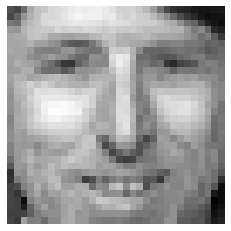

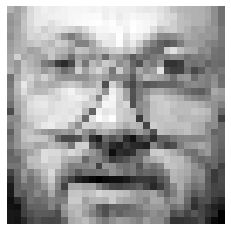

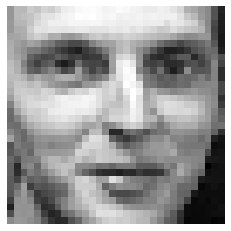

In [91]:
# Easiest faces to classify
show_single_face(data[easy_faces[0] * 10, :])
show_single_face(data[easy_faces[1] * 10, :])
show_single_face(data[easy_faces[2] * 10, :])

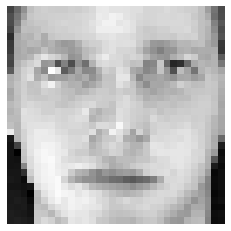

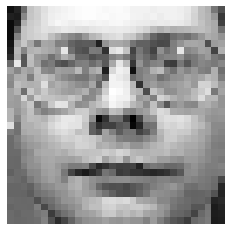

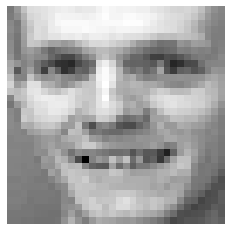

In [92]:
# Hardest faces to classify
show_single_face(data[hard_faces[0] * 10, :])
show_single_face(data[hard_faces[1] * 10, :])
show_single_face(data[hard_faces[2] * 10, :])

## 4. Gradient descent for training linear least squares model

In [97]:
def lls_gd_train(data, labels, learning_rate, N):
    """
      By supplying sufficient training samples and expected output the lls_gd_train function returns weights which are optimised for new
      samples by iterating over them a set number of times and updating them by a learning rate. The function simulates a gradient descent
      classification model by optimsing the given weights (that have an initial value of 0) with all training samples N times.

      data: matrix of size (N x d), so it has N rows, N being the number of input training samples, and d being the number of features,
            which in this case will be 1024, representing the number of pixels
      labels: matrix of size (N x c), so it has N rows, N being the number of expected output labels of the N input training samples,
            and c being the number of output values per sample which in this case will be 1024, representing the number of pixels
      learning_rate: floating point number which is the learning rate with which the gradient descent model can change the value
            of the objective function
      N: integer representing the number of iterations the gradient descent is going to go through, so the number of times the learning
            rate is going to be applied to the changed objective function

      Returns:
      cost_all: A 1-dimensional list which holds all values of the error loss through the set N iterations
      w_all: A 1-dimensional list which holds all values of the weights through the set N iterations; each matrix is of
            size (d+1 x c) with d being the number of features per sample plus one, which in this case will be 1025,
            representing the weights that will be applied to the values of a testing sample's pixels and c being the number of
            output values per sample 
      times_all: A 1-dimensional list which holds all elapsed times for each iteration; used for comparative analysis
      """

    X, y = data, labels
    sample_number = len(data)              # This will be N, the number of samples
    
    # Expand X with a column of ones.
    extension = np.ones((sample_number, 1), dtype=int)      # Column of 1s
    Xtilde = np.concatenate((extension, X), axis=1)         # Each sample starts wiht 1 now
    
    # Weight initialization
    w = np.zeros((1025,1))

    # Return value list initialization
    cost_all = []
    w_all = []
    times_all = []
    
    # GD update of weights
    for i in range(N):
        start = time.time()

        xtildtimesy = np.expand_dims((Xtilde.T @ y), axis = 1)
        gd = Xtilde.T @ Xtilde @ w - xtildtimesy

        
        predicted_y = np.sum((w.T * Xtilde), axis = 1)
        cost = 0.5 * np.sum((predicted_y - y) * (predicted_y - y))
        
        # Weight update
        w = w - learning_rate * (gd)
        end = time.time()
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost) 
        times_all.append(end - start)
      
    # Return model parameters.
    return cost_all, w_all, times_all

In [98]:
# Get the 1st and 30th subject's face data for training and testing
tr_ind, te_ind = partition_data(labels, num_per_class=3)

# We need only images of subject 1 and 30
tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

# Training samples and corresponding labels
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.array(tr_label, dtype=int) # Original returns uint8

# Testing samples and corresponding labels
te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.array(te_label, dtype=int) # Original returns uint8

learning_rate = 0.001
N = 200

# Using +1/-1 labelling
output_labels = tr_label.copy()
output_labels[tr_label == 1] = -1
output_labels[tr_label == 30] = 1

# Training weights
cost_all, w_all, times_all = lls_gd_train(tr_data, output_labels, learning_rate, N)

all_test_accuracy = []
for w in w_all:

    # Querying data with testing samples
    predicted_labels = l2_rls_predict(w, te_data)
    
    predicted_labels = np.squeeze(predicted_labels)
    predicted_labels[predicted_labels >= 0] = 30
    predicted_labels[predicted_labels < 0] = 1

    # Calculating test error
    test_result = te_label == predicted_labels
    incorrect_counter = 0
    for j in range(len(test_result)):
        if(not test_result[j]):
            incorrect_counter = incorrect_counter + 1

    curr_test_error = (incorrect_counter/len(test_result))
    all_test_accuracy.append(1 - curr_test_error)


all_train_accuracy = []
for w in w_all:

    # Querying data with training samples
    predicted_labels = l2_rls_predict(w, tr_data)

    predicted_labels = np.squeeze(predicted_labels)
    predicted_labels[predicted_labels >= 0] = 30
    predicted_labels[predicted_labels < 0] = 1

    # Calculating train error
    train_result = tr_label == predicted_labels
    incorrect_counter = 0
    for j in range(len(train_result)):
        if(not train_result[j]):
            incorrect_counter = incorrect_counter + 1

    curr_train_error = (incorrect_counter/len(train_result))
    all_train_accuracy.append(1 - curr_train_error)

Text(0.5, 1.0, 'Change in sum-of-squares error loss')

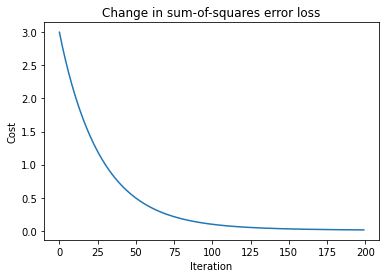

In [99]:
plt.plot(cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Change in sum-of-squares error loss")

Text(0.5, 1.0, 'Train error rates through iterations')

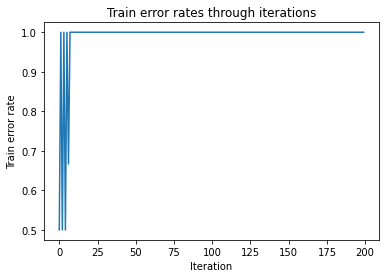

In [100]:
plt.plot(all_train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Train error rate')
plt.title("Train error rates through iterations")

Text(0.5, 1.0, 'Test error rates through iterations')

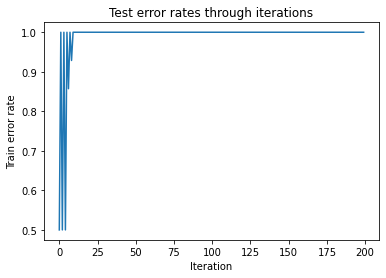

In [101]:
plt.plot(all_test_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Train error rate')
plt.title("Test error rates through iterations")

In [102]:
# Learning rate is 0.01
# Get the 1st and 30th subject's face data for training and testing
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.array(tr_label, dtype=int) # Original returns uint8

te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.array(te_label, dtype=int) # Original returns uint8

learning_rate = 0.01
N = 200

output_labels = tr_label.copy()
output_labels[tr_label == 1] = -1
output_labels[tr_label == 30] = 1

cost_all, w_all, times_all = lls_gd_train(tr_data, output_labels, learning_rate, N)
w = w_all[len(w_all) - 1]

predicted_labels = l2_rls_predict(w, te_data)
predicted_labels = np.squeeze(predicted_labels)
print(predicted_labels)

predicted_labels[predicted_labels >= 0] = 30
predicted_labels[predicted_labels < 0] = 1

test_result = te_label == predicted_labels
# Calculating test error
incorrect_counter = 0
for j in range(len(test_result)):
    if(not test_result[j]):
        incorrect_counter = incorrect_counter + 1

curr_test_error = (incorrect_counter/len(test_result))
print("Test error rate: ", curr_test_error)
print("")




all_test_accuracy = []
for w in w_all:

    # Querying data with testing samples
    predicted_labels = l2_rls_predict(w, te_data)
    
    predicted_labels = np.squeeze(predicted_labels)
    predicted_labels[predicted_labels >= 0] = 30
    predicted_labels[predicted_labels < 0] = 1

    # Calculating test error
    test_result = te_label == predicted_labels
    incorrect_counter = 0
    for j in range(len(test_result)):
        if(not test_result[j]):
            incorrect_counter = incorrect_counter + 1

    curr_test_error = (incorrect_counter/len(test_result))
    all_test_accuracy.append(1- curr_test_error)


all_train_accuracy = []
for w in w_all:

    # Querying data with training samples
    predicted_labels = l2_rls_predict(w, tr_data)

    predicted_labels = np.squeeze(predicted_labels)
    predicted_labels[predicted_labels >= 0] = 30
    predicted_labels[predicted_labels < 0] = 1

    # Calculating train error
    train_result = tr_label == predicted_labels
    incorrect_counter = 0
    for j in range(len(train_result)):
        if(not train_result[j]):
            incorrect_counter = incorrect_counter + 1

    curr_train_error = (incorrect_counter/len(train_result))
    all_train_accuracy.append(1 - curr_train_error)

C:\Users\klouc\AppData\Local\Temp\ipykernel_19824\4069239849.py:50: RuntimeWarning: overflow encountered in multiply
  cost = 0.5 * np.sum((predicted_y - y) * (predicted_y - y))


[1.63135710e+245 1.71632995e+245 1.56737734e+245 1.69588901e+245
 1.64188520e+245 1.72939757e+245 1.76123568e+245 1.43061743e+245
 1.41542795e+245 1.32974030e+245 1.32113283e+245 1.33799316e+245
 1.43769792e+245 1.42797760e+245]
Test error rate:  0.5



Text(0.5, 1.0, 'Change in sum-of-squares error loss')

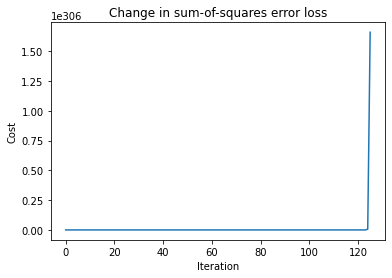

In [103]:
plt.plot(cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Change in sum-of-squares error loss")

Text(0.5, 1.0, 'Train error rates through iterations')

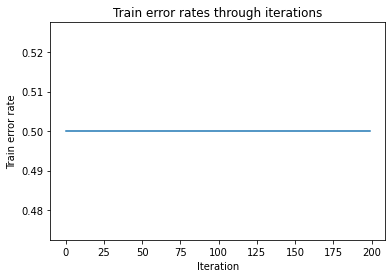

In [104]:
plt.plot(all_train_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Train error rate')
plt.title("Train error rates through iterations")

Text(0.5, 1.0, 'Test error rates through iterations')

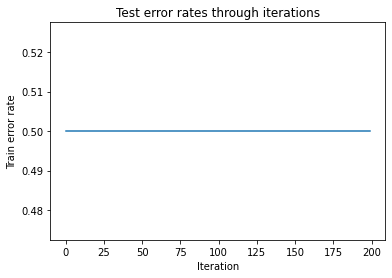

In [105]:
plt.plot(all_test_accuracy)
plt.xlabel('Iteration')
plt.ylabel('Train error rate')
plt.title("Test error rates through iterations")

## 5. Comparison between gradient descent training and stochastic gradient descent training

In [106]:
def lls_sgd_train(data, labels, learning_rate, N):
    """
      By supplying sufficient training samples and expected output the lls_sgd_train function returns weights which are optimised for new
      samples by iterating over them a set number of times and updating them by a learning rate. The function simulates a stochastic 
      gradient descent classification model by optimsing the given weights (that have an initial value of 0) with a random training sample
      from the set of all training samples N times.

      data: matrix of size (N x d), so it has N rows, N being the number of input training samples, and d being the number of features,
            which in this case will be 1024, representing the number of pixels
      labels: matrix of size (N x c), so it has N rows, N being the number of expected output labels of the N input training samples,
            and c being the number of output values per sample which in this case will be 1024, representing the number of pixels
      learning_rate: floating point number which is the learning rate with which the gradient descent model can change the value
            of the objective function
      N: integer representing the number of iterations the gradient descent is going to go through, so the number of times the learning
            rate is going to be applied to the changed objective function

      Returns:
      cost_all: A 1-dimensional list which holds all values of the error loss through the set N iterations
      w_all: A 1-dimensional list which holds all values of the weights through the set N iterations; each matrix is of
            size (d+1 x c) with d being the number of features per sample plus one, which in this case will be 1025,
            representing the weights that will be applied to the values of a testing sample's pixels and c being the number of
            output values per sample 
      times_all: A 1-dimensional list which holds all elapsed times for each iteration; used for comparative analysis
      """
    
    X, y = data, labels
    sample_number = len(data)              # This will be N, the number of samples
    
    # Expand X with a column of ones.
    extension = np.ones((sample_number, 1), dtype=int)   # Column of 1s
    Xtilde = np.concatenate((extension, X), axis=1)      # Each sample starts wiht 1 now
    
    # Weight initialization
    w = np.zeros((1025,1))
    cost_all = []
    w_all = []
    times_all = []
    
    # GD update of weights
    for i in range(N):
        start = time.time()

        # cost and gradient descent of the linear least squares model
        j = np.random.randint(0, sample_number - 1)
        curr_sample = np.expand_dims(Xtilde[j], axis = 0)
        curr_label = np.expand_dims(y[j], axis = 0)
        
        
        xtildtimesy = np.expand_dims(curr_sample.T @ curr_label, axis = 1)

        gd = curr_sample.T @ curr_sample @ w - xtildtimesy
        
        predicted_y = np.sum((w.T * Xtilde), axis = 1)
        cost = 0.5 * np.sum((predicted_y - y) * (predicted_y - y))
        
        # Weight update
        w = w - learning_rate * (gd)
        end = time.time()
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost) 
        times_all.append(end - start)
      
    
    # Return model parameters.
    return cost_all, w_all, times_all

In [107]:
# Get the 1st and 30th subject's face data for training and testing
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_ind = np.concatenate((tr_ind[0:3],tr_ind[87:90]))
te_ind = np.concatenate((te_ind[0:7],te_ind[203:210]))

# Training samples and corresponding labels
tr_data = np.squeeze(data[tr_ind, :])
tr_label = labels[tr_ind]
tr_label = np.array(tr_label, dtype=int) # Original returns uint8

# Testing samples and corresponding labels
te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.array(te_label, dtype=int) # Original returns uint8

# Using +1/-1 labelling
output_labels = tr_label.copy()
output_labels[tr_label == 1] = -1
output_labels[tr_label == 30] = 1

gd_learning_rate = 0.001
gd_N = 100

sgd1_learning_rate = 0.001
sgd1_N = 100

sgd_learning_rate = 0.001
sgd_N = 1000


# GD 100
gd_cost_all, gd_w_all, gd_times_all = lls_gd_train(tr_data, output_labels, gd_learning_rate, gd_N)
gd_w = gd_w_all[len(gd_w_all) - 1]

gd_predicted_labels = l2_rls_predict(gd_w, te_data)

gd_predicted_labels = np.squeeze(gd_predicted_labels)

gd_predicted_labels[gd_predicted_labels >= 0] = 30
gd_predicted_labels[gd_predicted_labels < 0] = 1
print(gd_predicted_labels)

# Calculating test error
gd_test_result = te_label == gd_predicted_labels
incorrect_counter = 0
for j in range(len(gd_test_result)):
    if(not gd_test_result[j]):
        incorrect_counter = incorrect_counter + 1

gd_test_error = (incorrect_counter/len(gd_test_result))



# SGD 100
sgd1_cost_all, sgd1_w_all, sgd1_times_all = lls_sgd_train(tr_data, output_labels, sgd1_learning_rate, sgd1_N)
sgd1_w = sgd1_w_all[len(sgd1_w_all) - 1]

sgd1_predicted_labels = l2_rls_predict(sgd1_w, te_data)

sgd1_predicted_labels = np.squeeze(sgd1_predicted_labels)
# print(sgd_predicted_labels)
sgd1_predicted_labels[sgd1_predicted_labels >= 0] = 30
sgd1_predicted_labels[sgd1_predicted_labels < 0] = 1
print(sgd1_predicted_labels)

# Calculating test error
sgd1_test_result = te_label == sgd1_predicted_labels
incorrect_counter = 0
for j in range(len(sgd1_test_result)):
    if(not sgd1_test_result[j]):
        incorrect_counter = incorrect_counter + 1

sgd1_test_error = (incorrect_counter/len(sgd1_test_result))


# SGD 1000
sgd_cost_all, sgd_w_all, sgd_times_all = lls_sgd_train(tr_data, output_labels, sgd_learning_rate, sgd_N)
sgd_w = sgd_w_all[len(sgd_w_all) - 1]

sgd_predicted_labels = l2_rls_predict(sgd_w, te_data)

sgd_predicted_labels = np.squeeze(sgd_predicted_labels)
# print(sgd_predicted_labels)
sgd_predicted_labels[sgd_predicted_labels >= 0] = 30
sgd_predicted_labels[sgd_predicted_labels < 0] = 1
print(sgd_predicted_labels)

# Calculating test error
sgd_test_result = te_label == sgd_predicted_labels
incorrect_counter = 0
for j in range(len(sgd_test_result)):
    if(not sgd_test_result[j]):
        incorrect_counter = incorrect_counter + 1

sgd_test_error = (incorrect_counter/len(sgd1_test_result))

print("")

# Elapsed time per iteration mean
print("## Elapsed times ##")
print("Average time per iteration (GD 100)", np.mean(gd_times_all))
print("Average time per iteration (SGD 100)", np.mean(sgd1_times_all))
print("Average time per iteration (SGD 1000)", np.mean(sgd_times_all))
print("")

#Test errors
print("## Test errors ##")
print("Test error (GD 100): ", gd_test_error)
print("Test error (SGD 100): ", sgd1_test_error)
print("Test error (SGD 1000): ", sgd_test_error)

[ 1. 30.  1.  1.  1.  1. 30. 30. 30. 30. 30. 30. 30. 30.]
[ 1. 30.  1. 30.  1.  1. 30. 30. 30. 30. 30. 30. 30. 30.]
[ 1. 30.  1.  1.  1.  1.  1. 30. 30. 30. 30. 30. 30. 30.]

## Elapsed times ##
Average time per iteration (GD 100) 0.005930910110473633
Average time per iteration (SGD 100) 0.004273016452789307
Average time per iteration (SGD 1000) 0.004514374017715454

## Test errors ##
Test error (GD 100):  0.14285714285714285
Test error (SGD 100):  0.21428571428571427
Test error (SGD 1000):  0.07142857142857142


Text(0.5, 1.0, 'Sum-of-squares error loss (100 Iterations GD)')

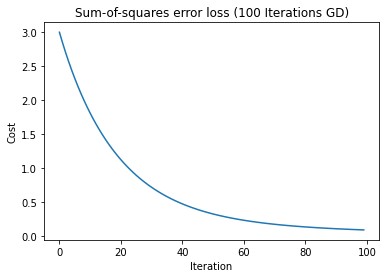

In [108]:
plt.plot(gd_cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Sum-of-squares error loss (100 Iterations GD)")
# plt.savefig("100GD")

Text(0.5, 1.0, 'Change in sum-of-squares error loss (100 Iterations SGD)')

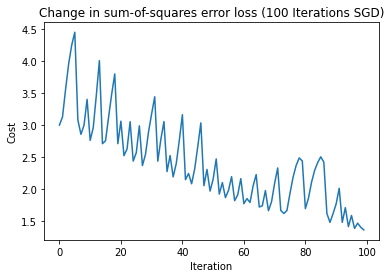

In [109]:
plt.plot(sgd1_cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Change in sum-of-squares error loss (100 Iterations SGD)")
# plt.savefig("100SGD")

Text(0.5, 1.0, 'Change in sum-of-squares error loss (1000 Iterations SGD)')

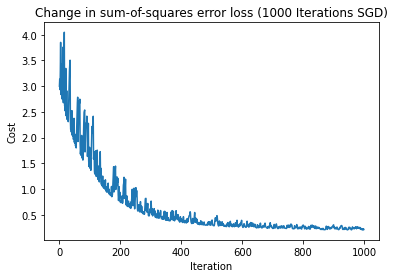

In [110]:
plt.plot(sgd_cost_all)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Change in sum-of-squares error loss (1000 Iterations SGD)")
# plt.savefig("1000SGD")